In [1]:
import os
from pathlib import Path
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr

In [2]:
parent = os.path.join(Path(os.getcwd()).parent)

print(parent)

sys.path.append(parent)

c:\Users\bruij_kn\OneDrive - Stichting Deltares\Documents\GitHub\thermo-morphological-model


In [3]:
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
save_path = Path("C:/Users/bruij_kn/OneDrive - Stichting Deltares/Documents/GitHub/msc-thesis/Figures/Python")

In [5]:
# reference variables
per_sa = {
    "start_time": pd.to_datetime("2018-01-01"), # these dates are relevant for the bluff edge only
    "end_time": pd.to_datetime("2019-01-01"),
}

I need:
- I need to extract total erosion of each variable, and check against baseline
- A way to differentiate between different types of tested variables

==> pd.DataFrame with columns for runid, sensitivity analysis level, sublevel, total erosion, and total erosion over baseline erosion.

In [6]:
# load overview dataframe
fpath_overview = Path("overview_sa.csv")
df = pd.read_csv(fpath_overview)

# get values for base run
fpath_base = Path("erosion_rates/sa_base.csv")
df_base = pd.read_csv(fpath_base, parse_dates=['time'])

x_start_base = df_base['x_bluff_edge'].values[0]
x_end_base = df_base['x_bluff_edge'].values[-1]
total_bluff_erosion_base = x_end_base - x_start_base

# initialize erosion
total_erosion = []
rnte = [] # relative normalized total erosion

# loop through all parameters
for i, row in df.iterrows():
    runid_low = row['run_id_low']
    runid_high = row['run_id_high']
    
    try:
        df_low = pd.read_csv(Path(f'erosion_rates/{runid_low}.csv'), parse_dates=['time'])
        df_high = pd.read_csv(Path(f'erosion_rates/{runid_high}.csv'), parse_dates=['time'])

        x_start_low = df_low['x_bluff_edge'].values[0]
        x_start_high = df_high['x_bluff_edge'].values[0]
        
        x_end_low = df_low['x_bluff_edge'].values[-1]
        x_end_high = df_high['x_bluff_edge'].values[-1]
        
        total_erosion_low = x_end_low - x_start_low
        total_erosion_high = x_end_high - x_start_high
        
        rnte_low = total_erosion_low / total_bluff_erosion_base
        rnte_high = total_erosion_high / total_bluff_erosion_base
        
        total_erosion.append((total_erosion_low, total_erosion_high))
        rnte.append((rnte_low, rnte_high))
    
    except FileNotFoundError:
        total_erosion.append((0, 0))
        rnte.append((0, 0))

    
# add new columns
total_erosion = np.array(total_erosion)
rnte = np.array(rnte)

df['total_erosion_low[m]'] = total_erosion[:,0]
df['total_erosion_high[m]'] = total_erosion[:,1]

df['rnte_low[-]'] = rnte[:,0]
df['rnte_high[-]'] = rnte[:,1]

df = df.iloc[:45]

# df

In [7]:
df_volume_changes = pd.read_csv("volume_changes.csv")

# df_volume_changes

In [8]:
volume_change_base = df_volume_changes[df_volume_changes.runid=='sa_base']['dV[m2]'].values[0]

volume_start_low = []
volume_end_low = []
volume_change_low = []

volume_start_high = []
volume_end_high = []
volume_change_high = []

for runid in df.run_id_low.values:
    volume_start_low.append(df_volume_changes[df_volume_changes.runid==runid]['V_start[m2]'].values[0])
    volume_end_low.append(df_volume_changes[df_volume_changes.runid==runid]['V_end[m2]'].values[0])
    volume_change_low.append(df_volume_changes[df_volume_changes.runid==runid]['dV[m2]'].values[0])
    
for runid in df.run_id_high.values:
    volume_start_high.append(df_volume_changes[df_volume_changes.runid==runid]['V_start[m2]'].values[0])
    volume_end_high.append(df_volume_changes[df_volume_changes.runid==runid]['V_end[m2]'].values[0])
    volume_change_high.append(df_volume_changes[df_volume_changes.runid==runid]['dV[m2]'].values[0])
    
df['volume_start_low[m2]'] = volume_start_low
df['volume_end_low[m2]'] = volume_end_low
df['volume_change_low[m2]'] = volume_change_low
df['volume_loss_low[m2]'] = -np.array(volume_change_low)

df['volume_start_high[m2]'] = volume_start_high
df['volume_end_high[m2]'] = volume_end_high
df['volume_change_high[m2]'] = volume_change_high
df['volume_loss_high[m2]'] = -np.array(volume_change_high)


In [9]:
# display(df)
display(df.tail())

print(len(df))

,varied_parameter,level,sublevel,number_low,number_high,baseline_value,unit,variation,new_value_low,new_value_high,...,rnte_low[-],rnte_high[-],volume_start_low[m2],volume_end_low[m2],volume_change_low[m2],volume_loss_low[m2],volume_start_high[m2],volume_end_high[m2],volume_change_high[m2],volume_loss_high[m2]
40,Sea temperature,2.0,thermodynamics,13.0,14.0,0,-,+-2,-2,+2,...,1.0,1.5,520.833328,502.010707,-18.822621,18.822621,520.833328,499.303245,-21.530082,21.530082
41,2m air temperature,2.0,thermodynamics,15.0,16.0,0,-,+-2,-2,+2,...,1.0,1.5,520.833328,506.147685,-14.685643,14.685643,520.833328,498.170366,-22.662962,22.662962
42,Latent heat flux,2.0,thermodynamics,17.0,18.0,1,-,+-10%,*0.8,*1.2,...,1.5,1.5,520.833328,498.946963,-21.886365,21.886365,520.833328,499.052539,-21.780789,21.780789
43,Thermal module,3.0,NaN,1.0,1.0,On,-,-1,Off,Off,...,2.0,2.0,520.833328,485.546713,-35.286615,35.286615,520.833328,485.546713,-35.286615,35.286615
44,Solar flux calcuator,3.0,NaN,2.0,2.0,On,-,-1,Off,Off,...,1.5,1.5,520.833328,498.358207,-22.475121,22.475121,520.833328,498.358207,-22.475121,22.475121


45


In [10]:
# order dataframe from low to high (choose between which parameter I want to order)
df['erosion_diff[m]'] = np.abs(df['total_erosion_high[m]'].values - df['total_erosion_low[m]'].values)
df['volume_change_diff[m2]'] = np.abs(df['volume_change_high[m2]'].values - df['volume_change_low[m2]'].values)
df['volume_change_total[m2]'] = np.abs(df['volume_change_high[m2]'].values - volume_change_base) +  np.abs(df['volume_change_low[m2]'].values - volume_change_base)

df = df.sort_values('volume_change_total[m2]')

In [11]:
# save this df
df.to_csv("overview_sa_post-processed.csv")

In [12]:
display(df.head())
display(df.tail())

,varied_parameter,level,sublevel,number_low,number_high,baseline_value,unit,variation,new_value_low,new_value_high,...,volume_end_low[m2],volume_change_low[m2],volume_loss_low[m2],volume_start_high[m2],volume_end_high[m2],volume_change_high[m2],volume_loss_high[m2],erosion_diff[m],volume_change_diff[m2],volume_change_total[m2]
12,Surface flux angle,1.0,model,25.0,26.0,20,degrees,+-20%,16,24,...,501.187691,-19.645637,19.645637,520.833328,501.181832,-19.651496,19.651496,0.0,0.005859,0.068194
4,Maximum nearshore depth,1.0,bathymetry,9.0,10.0,3,m,+-20%,2.4,3.6,...,500.980930,-19.852405,19.852405,520.833326,501.166594,-19.666732,19.666732,0.0,0.185673,0.185673
33,Latitude,1.0,physical,67.0,68.0,70.13,degrees,+-5%,66.6235,73.6365,...,500.912991,-19.920337,19.920337,520.833328,500.907561,-19.925767,19.925767,0.0,0.005430,0.480777
15,Maximum depth thermal module,1.0,model,31.0,32.0,15,m,+-20%,12,18,...,500.800377,-20.032951,20.032951,520.833328,500.856282,-19.977045,19.977045,0.0,0.055905,0.644669
9,Sea ice threshold,1.0,model,19.0,20.0,0.3,-,+-20%,0.24,0.36,...,500.988913,-19.844415,19.844415,520.833328,500.635854,-20.197474,20.197474,0.0,0.353059,0.676561


,varied_parameter,level,sublevel,number_low,number_high,baseline_value,unit,variation,new_value_low,new_value_high,...,volume_end_low[m2],volume_change_low[m2],volume_loss_low[m2],volume_start_high[m2],volume_end_high[m2],volume_change_high[m2],volume_loss_high[m2],erosion_diff[m],volume_change_diff[m2],volume_change_total[m2]
5,Nearshore slope,1.0,bathymetry,11.0,12.0,0.03,-,+-20%,0.024,0.036,...,504.732831,-16.100514,16.100514,520.833330,495.958847,-24.874483,24.874483,2.0,8.773969,8.773969
31,Melting temperature water,1.0,physical,63.0,64.0,273.15,K,+-1%,270.4185,275.8815,...,495.502261,-25.331066,25.331066,520.833328,509.330020,-11.503308,11.503308,2.0,13.827759,13.827759
1,Bluff slope,1.0,bathymetry,3.0,4.0,0.6,-,+-20%,0.48,0.72,...,519.218875,-6.822786,6.822786,517.361110,491.323667,-26.037443,26.037443,4.0,19.214657,19.214657
18,Critical dry slope,1.0,physical,37.0,38.0,0.6,-,+-20%,0.48,0.72,...,488.365731,-32.467596,32.467596,520.833328,510.539224,-10.294103,10.294103,6.0,22.173493,22.173493
43,Thermal module,3.0,NaN,1.0,1.0,On,-,-1,Off,Off,...,485.546713,-35.286615,35.286615,520.833328,485.546713,-35.286615,35.286615,0.0,0.000000,31.207903


We can make a tornado plot out of this!

In [13]:
value = df[df['varied_parameter']=='Thermal module'].new_value_low.values[0]
print(value)
# print(type(df[df['varied_parameter']=='thermal module'].new_value_low.values[0]))

# print(np.isnan(value))

Off


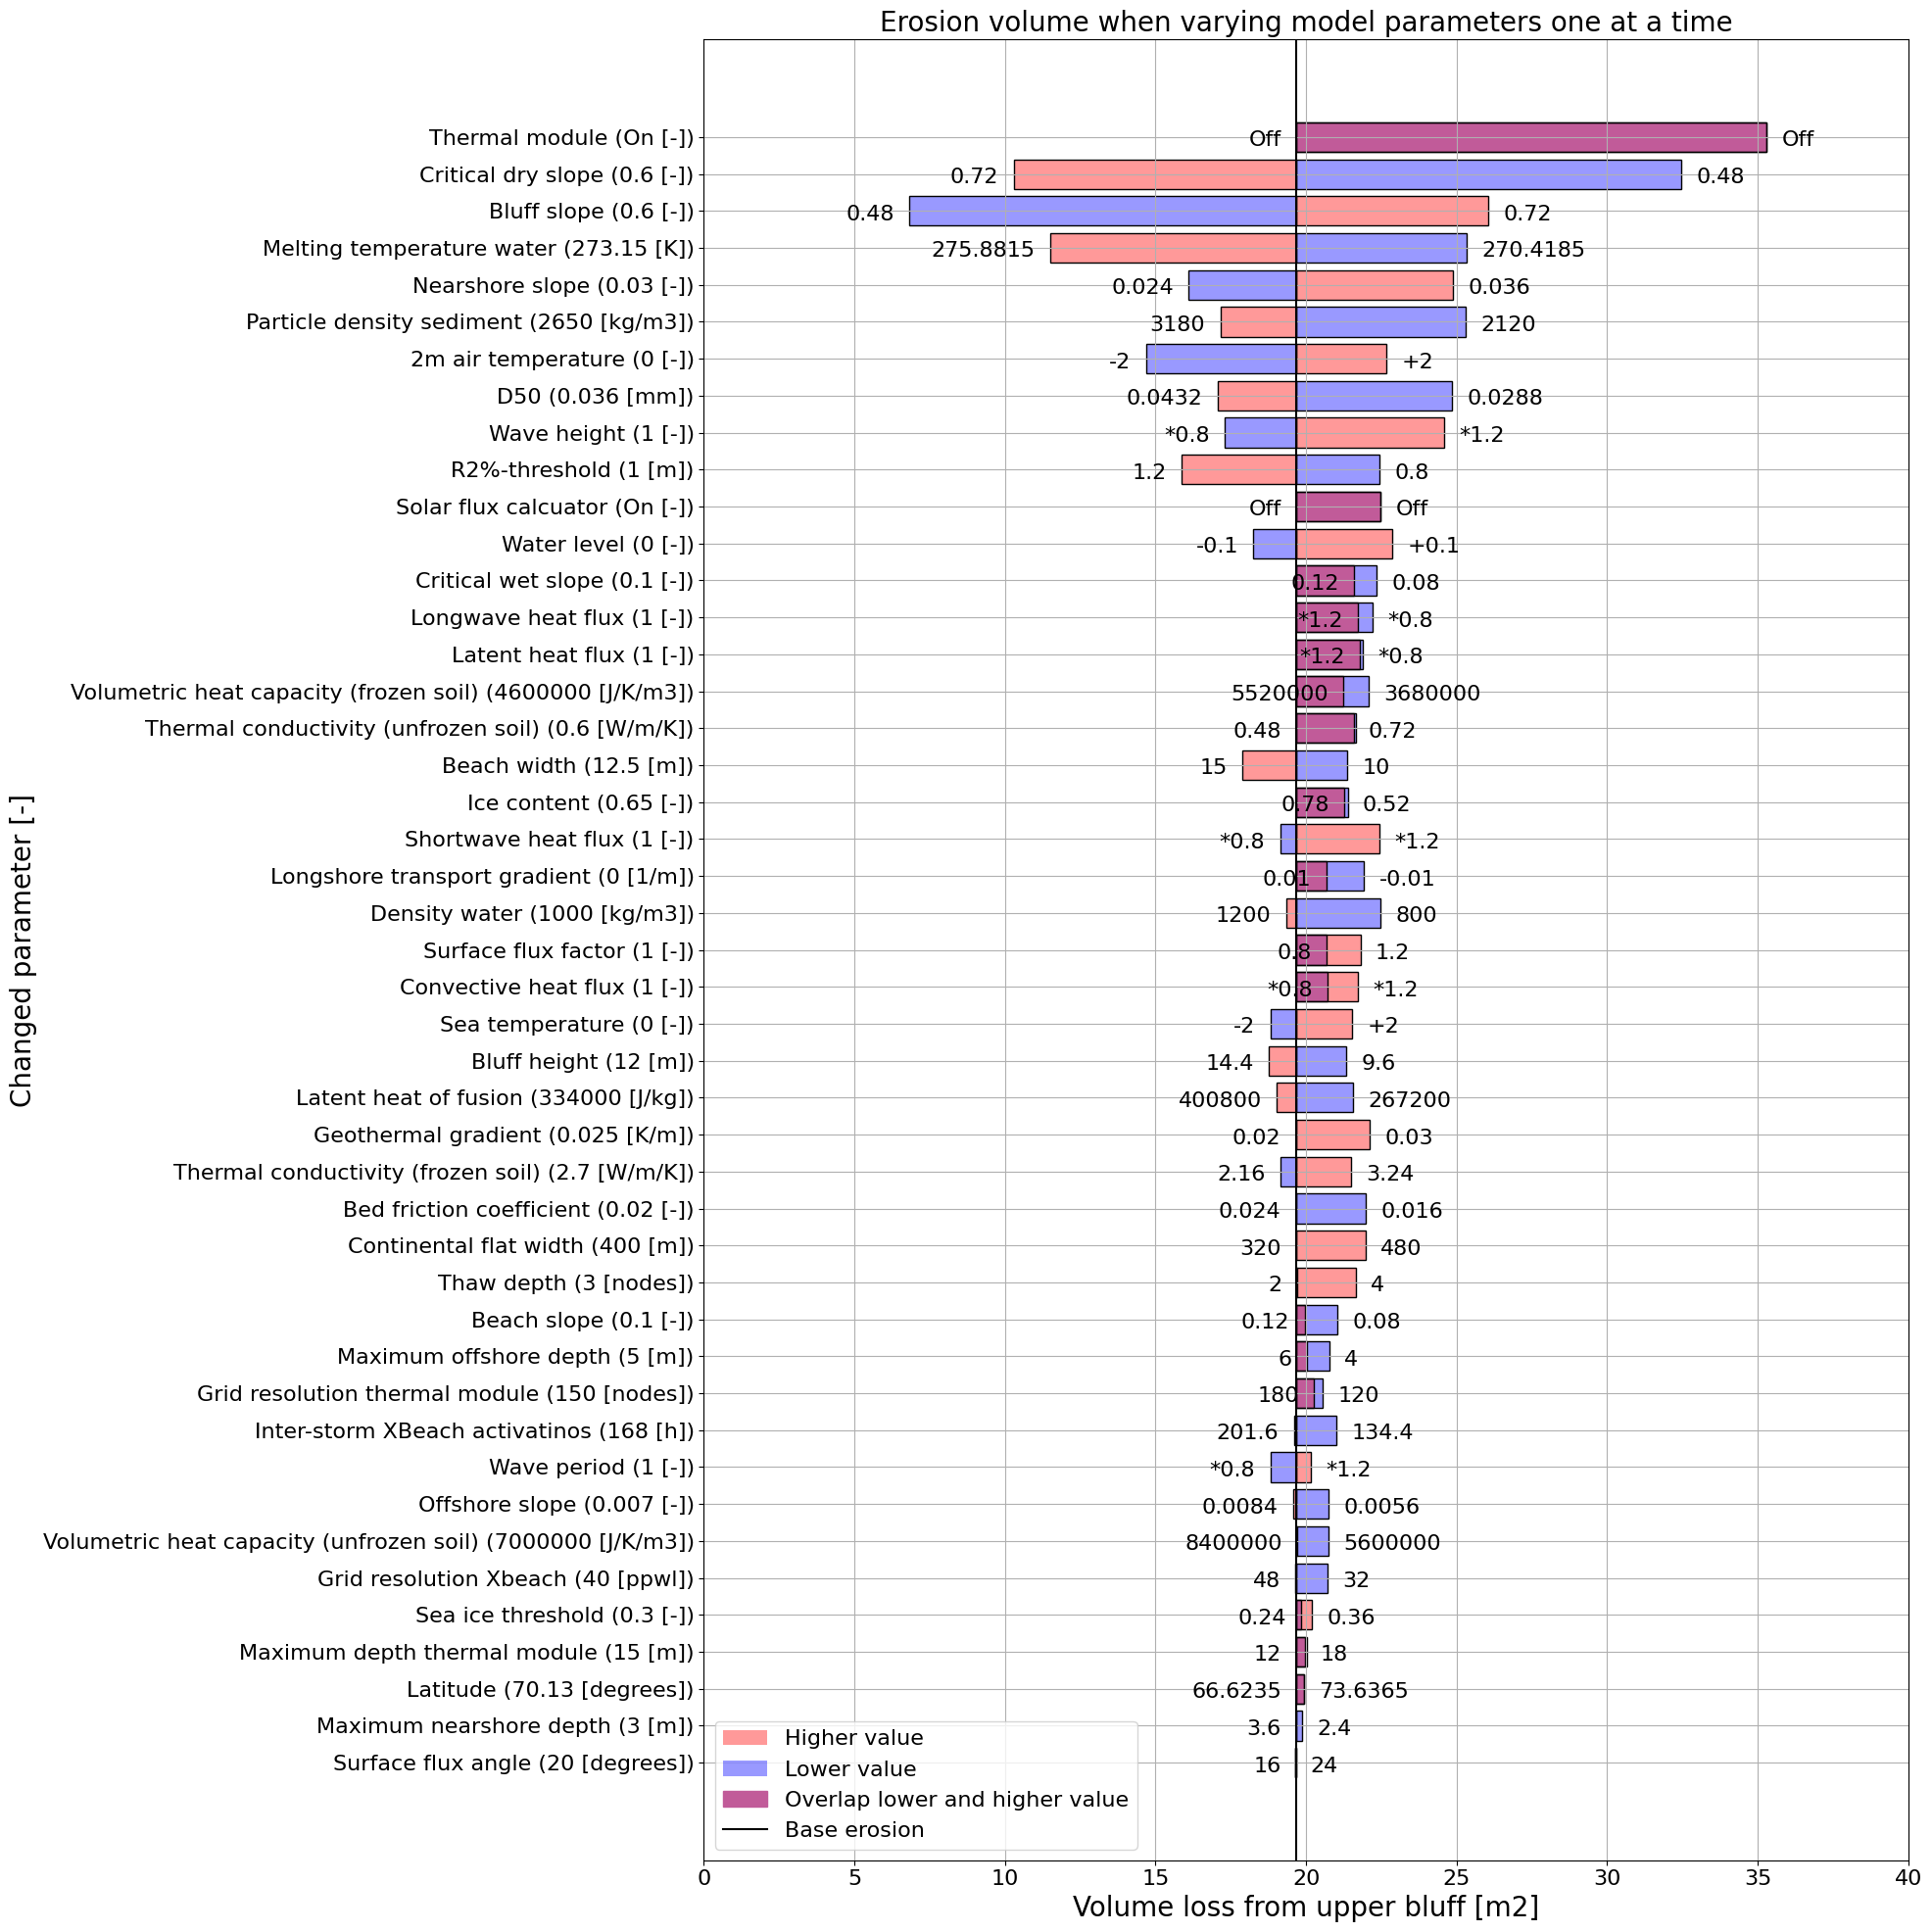

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))

# x_left = total_bluff_erosion_base
x_left = volume_change_base

ax.barh(np.arange(len(df)), width=df['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax.barh(np.arange(len(df)), width=df['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
outline1 = ax.barh(np.arange(len(df)), width=df['volume_loss_low[m2]'].values + x_left, left=-x_left, facecolor='None', edgecolor='k')
outline2 = ax.barh(np.arange(len(df)), width=df['volume_loss_high[m2]'].values + x_left, left=-x_left, facecolor='None', edgecolor='k')

# outline1.set_facecolor(None)

labels = [f'{df['varied_parameter'].values[i]} ({df['baseline_value'].values[i]} [{df['unit'].values[i]}])' for i in range(len(df))]
ax.set_yticks(np.arange(len(df)), labels)

for i in range(len(df)):
        
        if df['volume_loss_low[m2]'].values[i] <= df['volume_loss_high[m2]'].values[i]:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] - 5
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] + 1
            
            loc_low = df['volume_loss_low[m2]'].values[i] - 0.5
            loc_high = df['volume_loss_high[m2]'].values[i] + 0.5
            
            allignment_low = 'right'
            allignment_high = 'left'
        else:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] + 1
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] - 5
            
            loc_low = df['volume_loss_low[m2]'].values[i] + 0.5
            loc_high = df['volume_loss_high[m2]'].values[i] - 0.5
            
            allignment_low = 'left'
            allignment_high = 'right'
            
        if np.abs(df['volume_loss_low[m2]'].values[i] - df['volume_loss_high[m2]'].values[i]) < 0.1:
            allignment_low = 'right'
            loc_low = -volume_change_base - 0.5
            
            allignment_high = 'left'
            loc_high = df['volume_loss_high[m2]'].values[i] + 0.5
        
        try:
            text_low = df['new_value_low'].values[i] if not np.isnan(df['new_value_low'].values[i]) else ''
        except TypeError:
            text_low = df['new_value_low'].values[i]
        try:
            text_high = df['new_value_high'].values[i] if not np.isnan(df['new_value_high'].values[i]) else ''
        except TypeError:
            text_high = df['new_value_high'].values[i]
        
        ax.text(loc_low, np.arange(len(df))[i]-0.25, text_low, horizontalalignment=allignment_low)
        ax.text(loc_high, np.arange(len(df))[i]-0.25, text_high, horizontalalignment=allignment_high)

ax.axvline(-x_left, color='k', label='Base erosion')

ax.grid()

ax.set_title('Erosion volume when varying model parameters one at a time')

ax.fill_between([], [], [], color='#c15b99', label='Overlap lower and higher value')

h, l = ax.get_legend_handles_labels()

ax.legend(reversed(h), reversed(l), loc='lower left')

ax.set_xlabel('Volume loss from upper bluff [m2]')
ax.set_ylabel('Changed parameter [-]')

ax.set_xlim((0, 40))

fig.tight_layout()

figname = 'SA_all.png'

fig.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)

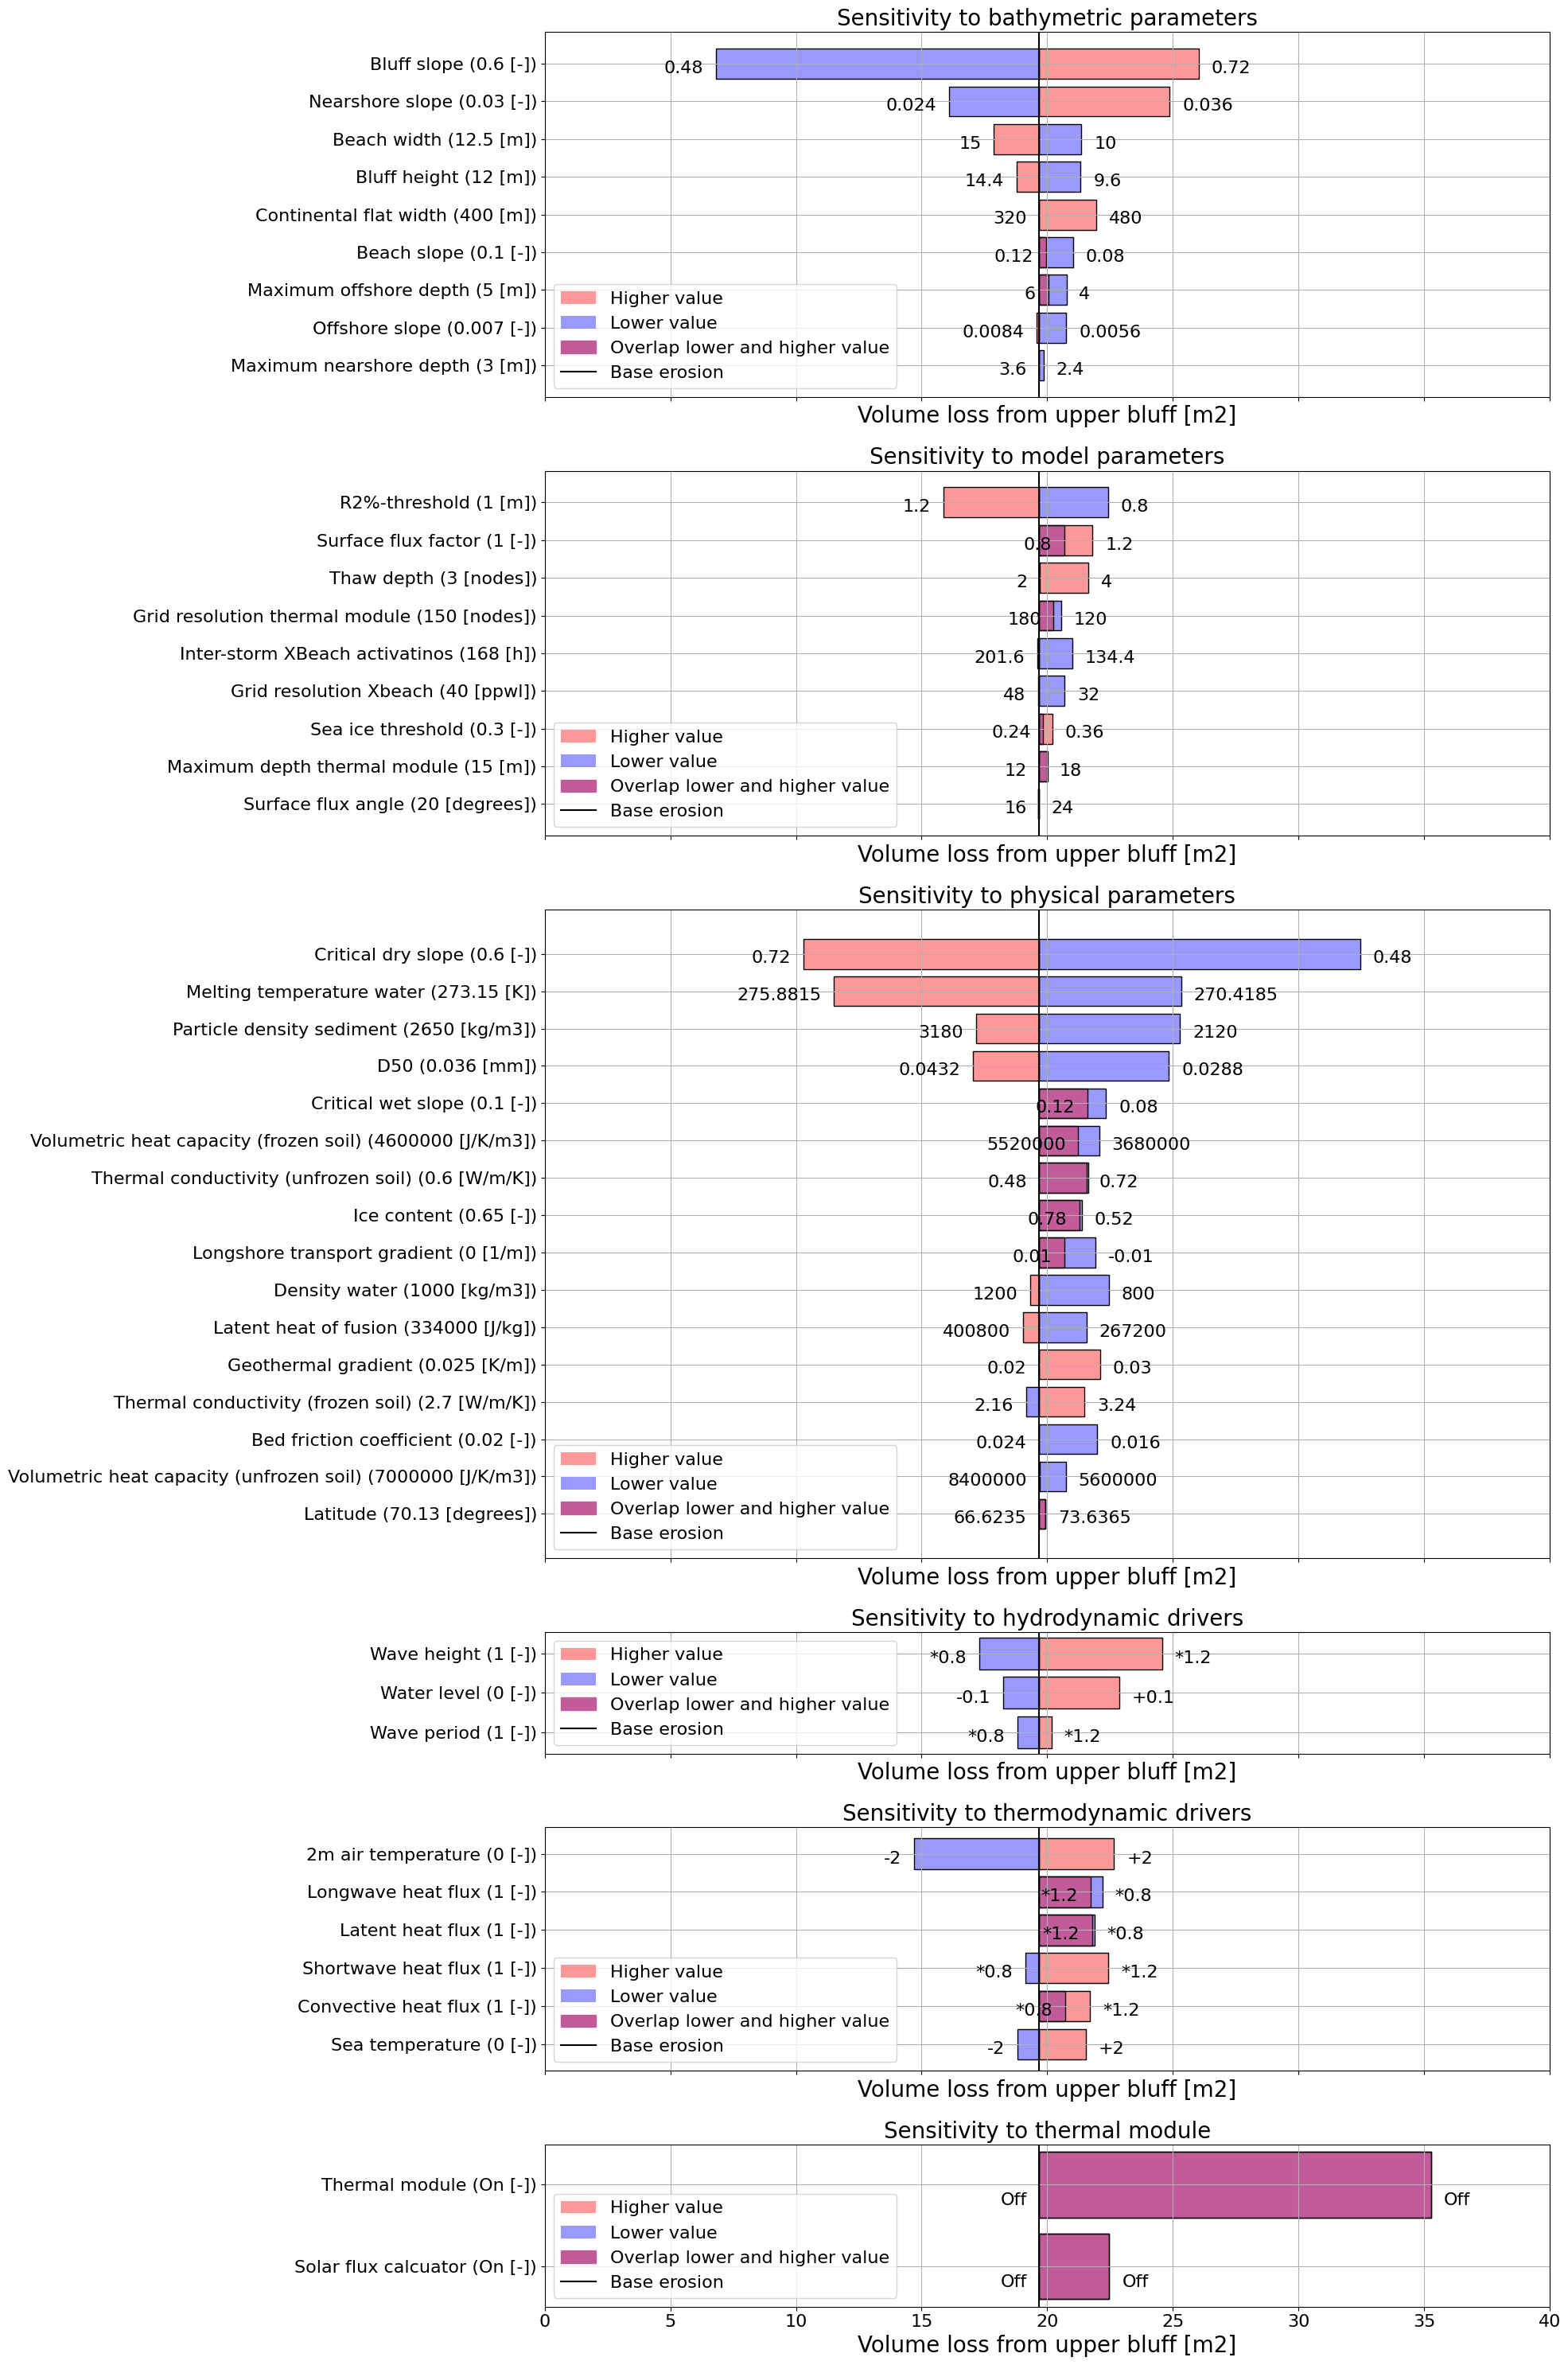

In [15]:
df_bathy = df[df['sublevel']=='bathymetry']
df_model = df[df['sublevel']=='model']
df_physi = df[df['sublevel']=='physical']
df_hydro = df[df['sublevel']=='hydrodynamics']
df_therm = df[df['sublevel']=='thermodynamics']
df_modul = df[df['level']==3]

x_left = volume_change_base

# figsize = (10, 15)

# fig0, ax0 = plt.subplots(figsize=(20, 20 * len(df_bathy) / len(df)))
# fig1, ax1 = plt.subplots(figsize=(20, 20 * len(df_model) / len(df)))
# fig2, ax2 = plt.subplots(figsize=(20, 20 * len(df_physi) / len(df)))
# fig3, ax3 = plt.subplots(figsize=(20, 20 * len(df_hydro) / len(df)))
# fig4, ax4 = plt.subplots(figsize=(20, 20 * len(df_therm) / len(df)))
# fig5, ax5 = plt.subplots(figsize=(20, 20 * len(df_modul) / len(df)))

hr = [
    len(df_bathy) / len(df),
    len(df_model) / len(df),
    len(df_physi) / len(df),
    len(df_hydro) / len(df),
    len(df_therm) / len(df),
    len(df_modul) / len(df) * 2,
]

fig, axs = plt.subplots(6, 1, figsize=(20, 30), sharex=True, height_ratios=hr)

ax0, ax1, ax2, ax3, ax4, ax5 = axs


ax0.barh(np.arange(len(df_bathy)), width=df_bathy['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax0.barh(np.arange(len(df_bathy)), width=df_bathy['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax0.barh(np.arange(len(df_bathy)), width=df_bathy['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax0.barh(np.arange(len(df_bathy)), width=df_bathy['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')

ax1.barh(np.arange(len(df_model)), width=df_model['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax1.barh(np.arange(len(df_model)), width=df_model['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax1.barh(np.arange(len(df_model)), width=df_model['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax1.barh(np.arange(len(df_model)), width=df_model['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')

ax2.barh(np.arange(len(df_physi)), width=df_physi['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax2.barh(np.arange(len(df_physi)), width=df_physi['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax2.barh(np.arange(len(df_physi)), width=df_physi['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax2.barh(np.arange(len(df_physi)), width=df_physi['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')

ax3.barh(np.arange(len(df_hydro)), width=df_hydro['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax3.barh(np.arange(len(df_hydro)), width=df_hydro['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax3.barh(np.arange(len(df_hydro)), width=df_hydro['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax3.barh(np.arange(len(df_hydro)), width=df_hydro['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')

ax4.barh(np.arange(len(df_therm)), width=df_therm['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax4.barh(np.arange(len(df_therm)), width=df_therm['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax4.barh(np.arange(len(df_therm)), width=df_therm['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax4.barh(np.arange(len(df_therm)), width=df_therm['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')

ax5.barh(np.arange(len(df_modul)), width=df_modul['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax5.barh(np.arange(len(df_modul)), width=df_modul['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
ax5.barh(np.arange(len(df_modul)), width=df_modul['volume_loss_low[m2]'].values + x_left, left=-x_left, color='None', ec='k')
ax5.barh(np.arange(len(df_modul)), width=df_modul['volume_loss_high[m2]'].values + x_left, left=-x_left, color='None', ec='k')


# axs[1, 1].barh(np.arange(len(df_therm)), width=df_therm['total_erosion_low[m]'].values, left=x_left, label='thermo Low', color='y')
# axs[1, 1].barh(np.arange(len(df_therm)), width=df_therm['total_erosion_high[m]'].values, left=x_left, label='thermo High', color='g')

for ax in [ax0, ax1, ax2, ax3, ax4, ax5]:
    ax.axvline(-x_left, color='k', label='Base erosion')

    ax.grid()

    ax.fill_between([], [], [], color='#c15b99', label='Overlap lower and higher value')

    h, l = ax.get_legend_handles_labels()

    ax.legend(reversed(h), reversed(l), loc='lower left')

    ax.set_xlabel('Volume loss from upper bluff [m2]')
    # ax.set_ylabel('Changed parameter [-]')
        
    ax.set_xlim((0, 40))

ax0.set_title('Sensitivity to bathymetric parameters')
ax1.set_title('Sensitivity to model parameters')
ax2.set_title('Sensitivity to physical parameters')
ax3.set_title('Sensitivity to hydrodynamic drivers')
ax4.set_title('Sensitivity to thermodynamic drivers')
ax5.set_title('Sensitivity to thermal module')

labels_bathy = [f'{df_bathy['varied_parameter'].values[i]} ({df_bathy['baseline_value'].values[i]} [{df_bathy['unit'].values[i]}])' for i in range(len(df_bathy))]
labels_model = [f'{df_model['varied_parameter'].values[i]} ({df_model['baseline_value'].values[i]} [{df_model['unit'].values[i]}])' for i in range(len(df_model))]
labels_physi = [f'{df_physi['varied_parameter'].values[i]} ({df_physi['baseline_value'].values[i]} [{df_physi['unit'].values[i]}])' for i in range(len(df_physi))]
labels_hydro = [f'{df_hydro['varied_parameter'].values[i]} ({df_hydro['baseline_value'].values[i]} [{df_hydro['unit'].values[i]}])' for i in range(len(df_hydro))]
labels_therm = [f'{df_therm['varied_parameter'].values[i]} ({df_therm['baseline_value'].values[i]} [{df_therm['unit'].values[i]}])' for i in range(len(df_therm))]
labels_modul = [f'{df_modul['varied_parameter'].values[i]} ({df_modul['baseline_value'].values[i]} [{df_modul['unit'].values[i]}])' for i in range(len(df_modul))]

ax0.set_yticks(np.arange(len(df_bathy)), labels_bathy)
ax1.set_yticks(np.arange(len(df_model)), labels_model)
ax2.set_yticks(np.arange(len(df_physi)), labels_physi)
ax3.set_yticks(np.arange(len(df_hydro)), labels_hydro)
ax4.set_yticks(np.arange(len(df_therm)), labels_therm)
ax5.set_yticks(np.arange(len(df_modul)), labels_modul)

for dfi, ax in zip([df_bathy, df_model, df_physi, df_hydro, df_therm, df_modul], [ax0, ax1, ax2, ax3, ax4, ax5]):

    for i in range(len(dfi)):
        
        if dfi['volume_loss_low[m2]'].values[i] <= dfi['volume_loss_high[m2]'].values[i]:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] - 5
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] + 1
            
            loc_low = dfi['volume_loss_low[m2]'].values[i] - 0.5
            loc_high = dfi['volume_loss_high[m2]'].values[i] + 0.5
            
            allignment_low = 'right'
            allignment_high = 'left'
        else:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] + 1
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] - 5
            
            loc_low = dfi['volume_loss_low[m2]'].values[i] + 0.5
            loc_high = dfi['volume_loss_high[m2]'].values[i] - 0.5
            
            allignment_low = 'left'
            allignment_high = 'right'
        
        if np.abs(dfi['volume_loss_low[m2]'].values[i] - dfi['volume_loss_high[m2]'].values[i]) < 0.1:
            allignment_low = 'right'
            loc_low = -volume_change_base - 0.5
            
            allignment_high = 'left'
            loc_high = dfi['volume_loss_high[m2]'].values[i] + 0.5
            
        try:
            text_low = dfi['new_value_low'].values[i] if not np.isnan(dfi['new_value_low'].values[i]) else ''
        except TypeError:
            text_low = dfi['new_value_low'].values[i]
        try:
            text_high = dfi['new_value_high'].values[i] if not np.isnan(dfi['new_value_high'].values[i]) else ''
        except TypeError:
            text_high = dfi['new_value_high'].values[i]
            
                
        ax.text(loc_low, np.arange(len(dfi))[i]-0.25, text_low, horizontalalignment=allignment_low)
        ax.text(loc_high, np.arange(len(dfi))[i]-0.25, text_high, horizontalalignment=allignment_high)

# fig0.tight_layout()
# fig1.tight_layout()
# fig2.tight_layout()
# fig3.tight_layout()
# fig4.tight_layout()
# fig5.tight_layout()

# figname0 = 'SA_ordered_bathy.png'
# figname1 = 'SA_ordered_model.png'
# figname2 = 'SA_ordered_physi.png'
# figname3 = 'SA_ordered_hydro.png'
# figname4 = 'SA_ordered_therm.png'
# figname5 = 'SA_ordered_modul.png'

# fig0.savefig(os.path.join(save_path, figname0), bbox_inches='tight', facecolor='white', transparent=False)
# fig1.savefig(os.path.join(save_path, figname1), bbox_inches='tight', facecolor='white', transparent=False)
# fig2.savefig(os.path.join(save_path, figname2), bbox_inches='tight', facecolor='white', transparent=False)
# fig3.savefig(os.path.join(save_path, figname3), bbox_inches='tight', facecolor='white', transparent=False)
# fig4.savefig(os.path.join(save_path, figname4), bbox_inches='tight', facecolor='white', transparent=False)
# fig5.savefig(os.path.join(save_path, figname5), bbox_inches='tight', facecolor='white', transparent=False)

fig.tight_layout()

figname = 'SA_ordered.png'

fig.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)


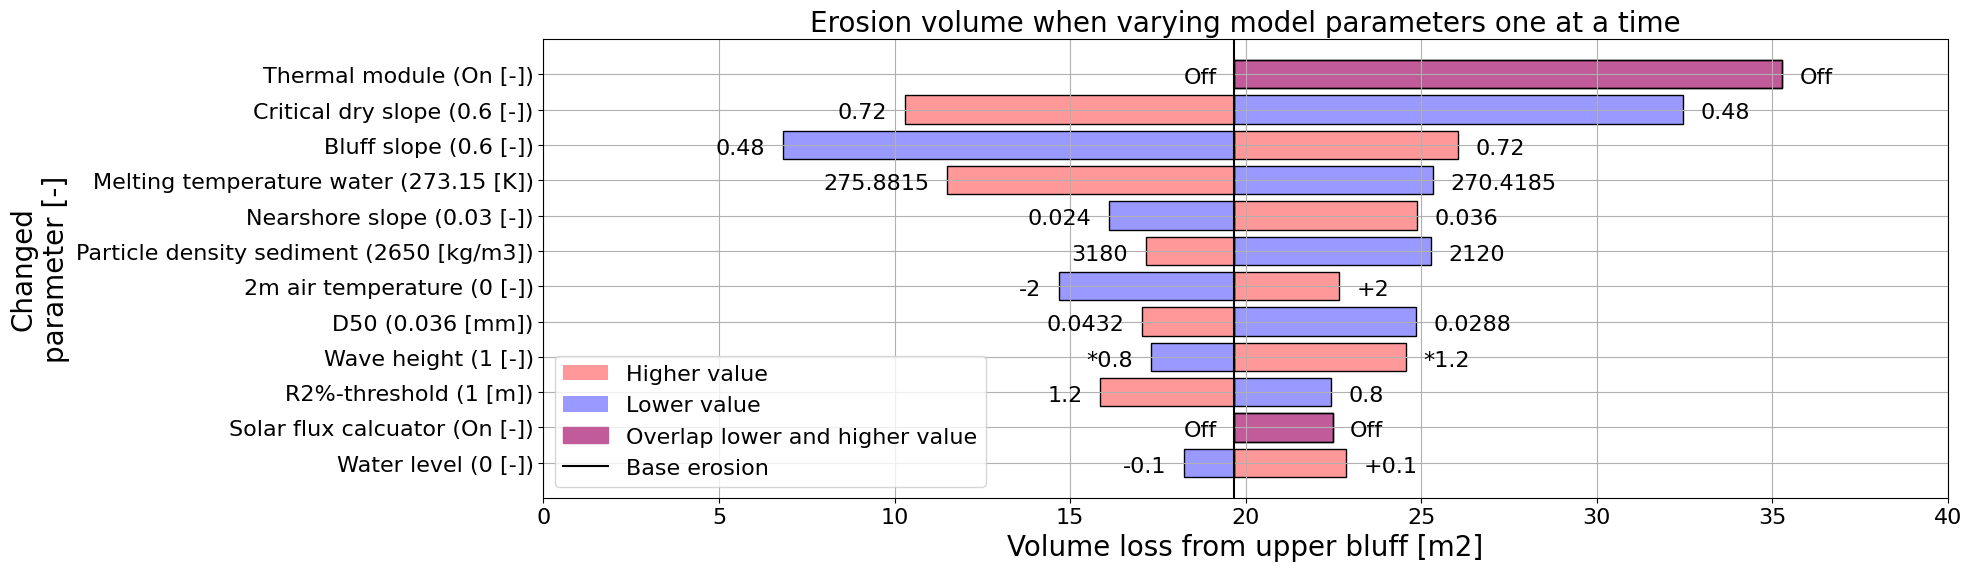

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))

N_top_values = 12

# x_left = total_bluff_erosion_base
x_left = volume_change_base

# only take subset of df
# dfi = df[df['Exception']==0][-N_top_values:]
dfi = df[-N_top_values:]

ax.barh(np.arange(len(dfi)), width=dfi['volume_loss_low[m2]'].values + x_left, left=-x_left, label='Lower value', color='b', alpha=0.4)
ax.barh(np.arange(len(dfi)), width=dfi['volume_loss_high[m2]'].values + x_left, left=-x_left, label='Higher value', color='r', alpha=0.4)
outline1 = ax.barh(np.arange(len(dfi)), width=dfi['volume_loss_low[m2]'].values + x_left, left=-x_left, facecolor='None', edgecolor='k')
outline2 = ax.barh(np.arange(len(dfi)), width=dfi['volume_loss_high[m2]'].values + x_left, left=-x_left, facecolor='None', edgecolor='k')

# outline1.set_facecolor(None)

labels = [f'{dfi['varied_parameter'].values[i]} ({dfi['baseline_value'].values[i]} [{dfi['unit'].values[i]}])' for i in range(len(dfi))]
ax.set_yticks(np.arange(len(dfi)), labels)

for i in range(len(dfi)):
        
        if dfi['volume_loss_low[m2]'].values[i] <= dfi['volume_loss_high[m2]'].values[i]:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] - 5
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] + 1
            
            loc_low = dfi['volume_loss_low[m2]'].values[i] - 0.5
            loc_high = dfi['volume_loss_high[m2]'].values[i] + 0.5
            
            allignment_low = 'right'
            allignment_high = 'left'
        else:
            
            # loc_low = df_bathy['volume_loss_low[m2]'].values[i] + 1
            # loc_high = df_bathy['volume_loss_high[m2]'].values[i] - 5
            
            loc_low = dfi['volume_loss_low[m2]'].values[i] + 0.5
            loc_high = dfi['volume_loss_high[m2]'].values[i] - 0.5
            
            allignment_low = 'left'
            allignment_high = 'right'
            
        if np.abs(dfi['volume_loss_low[m2]'].values[i] - dfi['volume_loss_high[m2]'].values[i]) < 0.1:
            allignment_low = 'right'
            loc_low = -volume_change_base - 0.5
            
            allignment_high = 'left'
            loc_high = dfi['volume_loss_high[m2]'].values[i] + 0.5
        
        try:
            text_low = dfi['new_value_low'].values[i] if not np.isnan(dfi['new_value_low'].values[i]) else ''
        except TypeError:
            text_low = dfi['new_value_low'].values[i]
        try:
            text_high = dfi['new_value_high'].values[i] if not np.isnan(dfi['new_value_high'].values[i]) else ''
        except TypeError:
            text_high = dfi['new_value_high'].values[i]
        
        ax.text(loc_low, np.arange(len(dfi))[i]-0.25, text_low, horizontalalignment=allignment_low)
        ax.text(loc_high, np.arange(len(dfi))[i]-0.25, text_high, horizontalalignment=allignment_high)

ax.axvline(-x_left, color='k', label='Base erosion')

ax.grid()

ax.set_title('Erosion volume when varying model parameters one at a time')

ax.fill_between([], [], [], color='#c15b99', label='Overlap lower and higher value')

h, l = ax.get_legend_handles_labels()

ax.legend(reversed(h), reversed(l), loc='lower left')

ax.set_xlabel('Volume loss from upper bluff [m2]')
ax.set_ylabel('Changed\nparameter [-]')

ax.set_xlim((0, 40))

fig.tight_layout()

figname = 'SA_top.png'

fig.savefig(os.path.join(save_path, figname), bbox_inches='tight', facecolor='white', transparent=False)